In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import sys
import json

import argparse

from dataclasses import dataclass

In [3]:

from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline

In [4]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [5]:
# where WellClass and Ga[ codes are located
sys.path.append('../')

In [6]:

from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser,
)

# WellClass
from src.WellClass.libs.well_class import Well

from src.WellClass.libs.grid_utils import (
    WellDataFrame,
    GridCoarse,
    GridRefine,
    LGRBuilder,
)

# plots
from src.WellClass.libs.plotting import (
    plot_grid,
)


## Some user options

In [7]:
# TODO(hzh): use Ali's algorithm
Ali_way = True


In [8]:
# use yaml or csv input file
use_yaml = True


In [9]:

# pick an example from given three options

case_type = 'cosmo'

case_type = 'smeaheia_v1'

# case_type = 'smeaheia_v2'

In [10]:
# where test data located
data_path = '../'

## Examples

In [11]:

# # Examples
# The following are the test examples.

# examples
smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
            'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 
            'sim_path': os.path.join(data_path, './test_data/examples/smeaheia_v1'),
            'simcase': r'GEN_NOLGR_PH2'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
            'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 
            'sim_path': os.path.join(data_path, './test_data/examples/smeaheia_v2'), 
            'simcase': r'TEMP-0'}
cosmo = {
        'well_input': r'GaP_input_Cosmo_v3.csv', 
        'well_input_yaml': r'cosmo.yaml', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
        'sim_path': os.path.join(data_path, './test_data/examples/cosmo'), 
        'simcase': r'TEMP-0'}

examples = {
    'smeaheia_v1': smeaheia_v1,
    'smeaheia_v2': smeaheia_v2,
    'cosmo': cosmo
}


In [12]:

@dataclass                # @dataclass(kw_only=True)
class Arguments:
    ali_way: bool
    use_yaml: bool
    case_type: str
    output_dir: str = '.'
    output_name: str = 'LEG_HIRES'
    plot: bool = True

In [13]:

args = Arguments(ali_way=Ali_way, use_yaml=use_yaml, case_type=case_type)

In [14]:


############# 0. User options ######################

# TODO(hzh): use Ali's grid logic
Ali_way = args.ali_way

# use yaml or csv input file
use_yaml = args.use_yaml

# pick an example from given three options: 
#  i.e, smeaheia_v1, smeaheia_v2 and cosmo
case_type = args.case_type

# output
output_dir = args.output_dir
# LRG name 
LGR_NAME = args.output_name


In [15]:

############# 1. Selected case ####################

# the selected example for testing
case = examples[case_type]

# where the location for the input parameters and eclipse .EGRID and .INIT files
sim_path = case['sim_path']


## Load well configuration file

In [16]:

############ 2. Load well configuration file ###############

if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input_yaml'])
    
    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input'])

    # load the well information
    well_csv = csv_parser(well_name)


## Build well class

In [17]:

########### 3. build Well class ######################

# build well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
        )

# to well dataframe
well_df = WellDataFrame(my_well)

# for convenience

# extract dataframes
annulus_df = well_df.annulus_df
drilling_df = well_df.drilling_df
casings_df = well_df.casings_df
borehole_df = well_df.borehole_df

barriers_mod_df = well_df.barriers_mod_df


## Coarse, LGR and Refine grids

In [18]:

############### 4. various grids #####################

##### 4.1 grid_coarse 

# location of .egrid
simcase = os.path.join(sim_path, case['simcase'])

# Loading the model
grid_coarse = GridCoarse(simcase)

##### 4.2 LGR grid 

# LGR grid information in x, y, z directions
lgr = LGRBuilder(grid_coarse, 
                annulus_df, 
                drilling_df, casings_df, borehole_df,
                Ali_way)

##### 4.3 grid_refine 

# Set up dataframe for LGR mesh
grid_refine = GridRefine(grid_coarse,
                        lgr.LGR_sizes_x, lgr.LGR_sizes_y, 
                        lgr.LGR_sizes_z, 
                        )


Minimimum grid size is 5.00 cm
nx=26, ny=26, nz=172


## Build LGR grids

In [19]:

############### 5. build LGR #####################

# set up permeability
grid_refine.build_LGR(drilling_df, casings_df, barriers_mod_df)


## Output .grdel file

In [20]:

########### 6. output grdecl file ###################

# Write LGR file
lgr.build_grdecl(output_dir, LGR_NAME,
                    drilling_df,
                    casings_df,
                    barriers_mod_df)


DEBUG ==============> handling open hole section
...Prints isolating OVB from reservoir keywords in LEG_HIRES.grdecl file
...Prints CARFIN Keywords in LEG_HIRES.grdecl file
...Prints Casings, cement bonds and barrie(s) in LEG_HIRES.grdecl file
...Prints isolating OVB from reservoir in the LGR in LEG_HIRES.grdecl file
Output LGR CARFIN to:  /scratch/SCS/hzh/SCREEN/notebooks/LEG_HIRES.grdecl


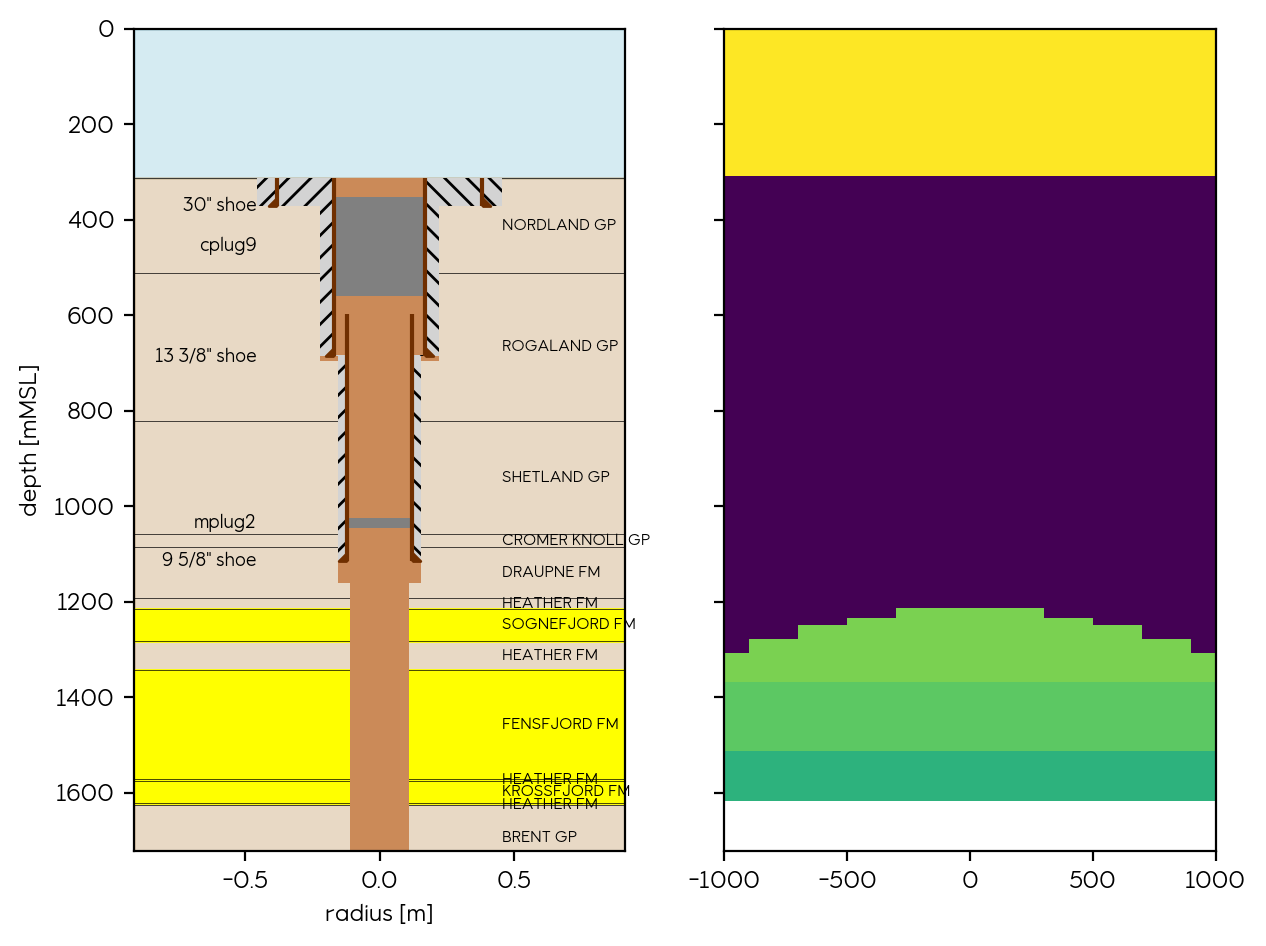

In [21]:

# for qc
if args.plot:
    plot_grid(my_well, grid_coarse)

    


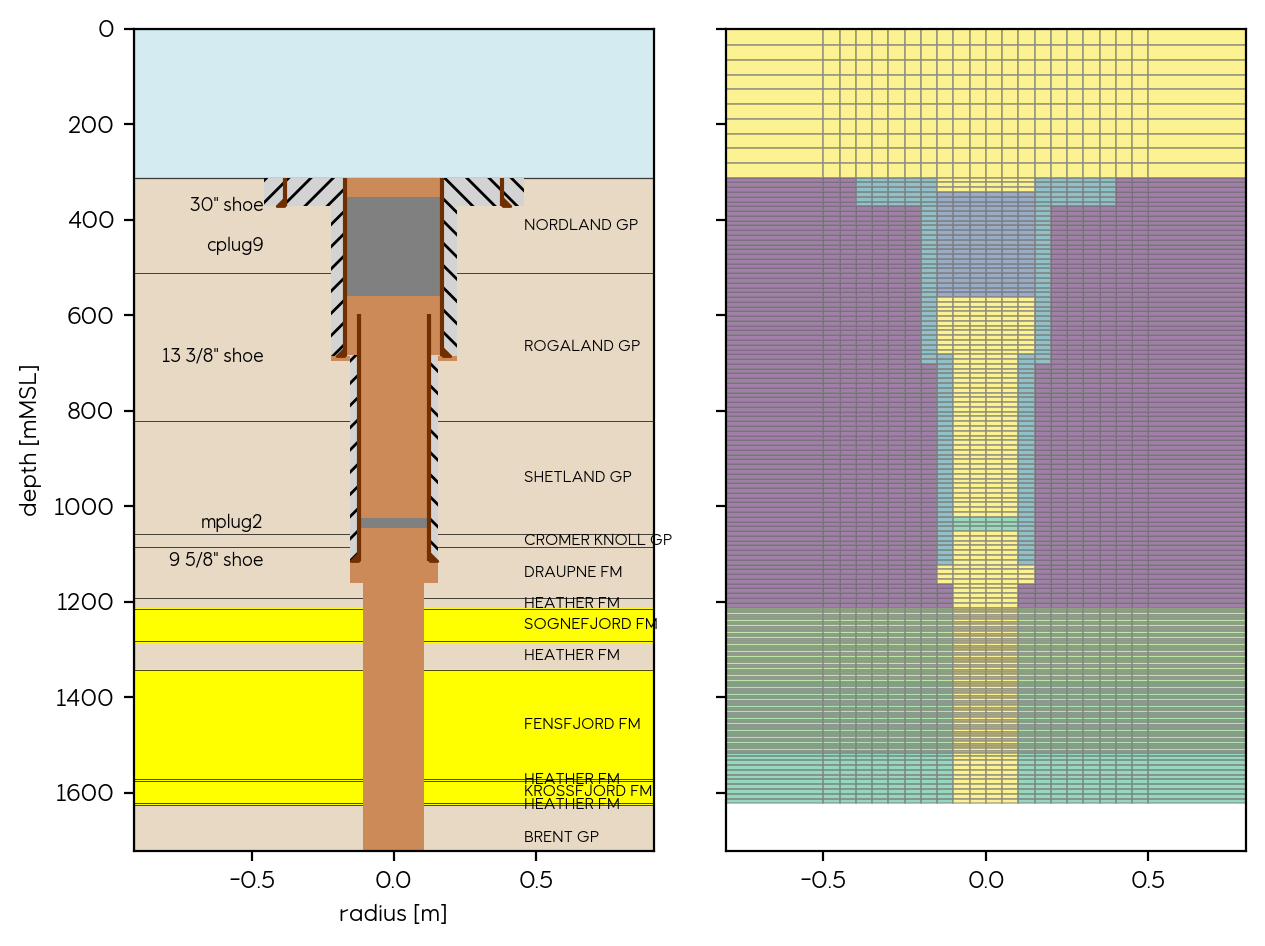

In [22]:
if args.plot:
    plot_grid(my_well, grid_refine)



## Compare output

Only when we are using 'smeaheia_v1' dataset and using Ali's grid logic

In [23]:
!ls -l LEG_HIRES.grdecl*

-rw-rw-r-- 1 hzh scs_ccs 5879 Sep 22 21:52 LEG_HIRES.grdecl
-rw-rw-r-- 1 hzh scs_ccs 5383 Sep 22 17:29 LEG_HIRES.grdecl.smeaheia


In [24]:
# check the results, only compare smeaheia_v1
if case_type == 'smeaheia_v1' and Ali_way:
    !diff LEG_HIRES.grdecl LEG_HIRES.grdecl.smeaheia

31,36c31,36
< --pipe with ID of 29.99994 and perm of 10000.0  were set in LEG_HIRES Local Grid refinement
< PERMX  10000.0  6  21  6  21  10  16  /
< PERMY  10000.0  6  21  6  21  10  16  /
< PERMZ  10000.0  6  21  6  21  10  16  /
< PORO  0.99  6  21  6  21  10  16  /
< SATNUM  2  6  21  6  21  10  16  /
---
> --pipe with ID of 29.99994 and perm of 10000  were set in LEG_HIRES Local Grid refinement
> PERMX  10000  6  21  6  21  1  16  /
> PERMY  10000  6  21  6  21  1  16  /
> PERMZ  10000  6  21  6  21  1  16  /
> PORO  0.99  6  21  6  21  1  16  /
> SATNUM  2  6  21  6  21  1  16  /
48c48
< --cement around pipe with ID of 29.99994  and perm of 5.0  were set in LEG_HIRES
---
> --cement around pipe with ID of 29.99994  and perm of 5  were set in LEG_HIRES
50,52c50,52
< PERMX  5.0  5  22  5  5  10  16  /
< PERMY  5.0  5  22  5  5  10  16  /
< PERMZ  5.0  5  22  5  5  10  16  /
---
> PERMX  5  5  22  5  5  10  16  /
> PERMY  5  5  22  5  5  10  16  /
> PERMZ  5  5  22  5  5  10  16  /
5